In [1]:
!pip install -q roboflow opencv-python-headless ultralytics gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 

In [2]:
import cv2
import os
import gdown
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
import torch
import gc

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Загрузка видео

file_id = "19cRV6j2bz7VDQRPuwxxXCORMyqDA61MJ"
url = f"https://drive.google.com/uc?id={file_id}"
output = "curling_end.mp4"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19cRV6j2bz7VDQRPuwxxXCORMyqDA61MJ
From (redirected): https://drive.google.com/uc?id=19cRV6j2bz7VDQRPuwxxXCORMyqDA61MJ&confirm=t&uuid=0ffc462d-3cd7-49a5-88fd-544ca4c373d7
To: /content/curling_end.mp4
100%|██████████| 257M/257M [00:03<00:00, 84.8MB/s]


'curling_end.mp4'

In [4]:
# Извлечение кадров

video_path = "curling_end.mp4"

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Частота кадров
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Всего кадров в видео: {total_frames}, FPS: {frame_rate}")

frame_id = 0
saved_count = 0
frame_step = 5  # сохраняем каждый 5-й кадр

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_id % frame_step == 0:
        filename = os.path.join(output_dir, f"frame_{frame_id:05d}.jpg")
        cv2.imwrite(filename, frame)
        saved_count += 1

    frame_id += 1

cap.release()
print(f"Сохранено кадров: {saved_count}")

Всего кадров в видео: 8798, FPS: 9.99919419996729
Сохранено кадров: 1760


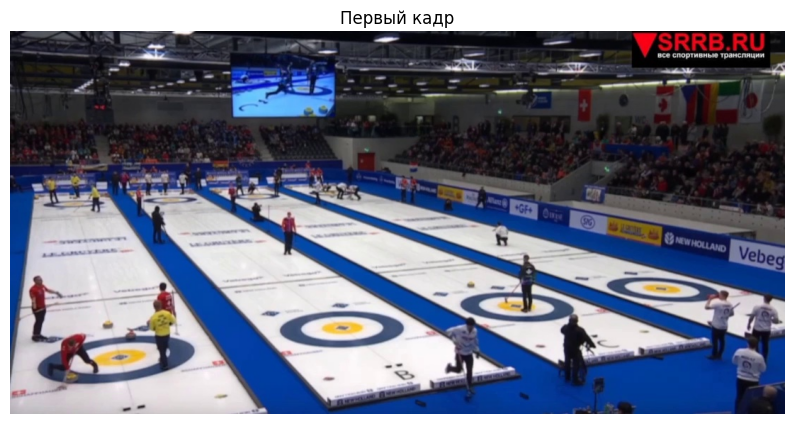

In [5]:
img_path = os.path.join(output_dir, "frame_00000.jpg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Первый кадр")
plt.show()

In [6]:
from PIL import Image
folder = '/content/frames'
images = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

# Проверим размер первого изображения
img_path = os.path.join(folder, images[0])
with Image.open(img_path) as img:
    width, height = img.size
    print(f"Размер изображения: {width}x{height}")

Размер изображения: 1094x540


In [7]:
# Собственный датасет из RoboFlow с домом и хог-линией

rf = Roboflow(api_key="Bo6emED703twIQ1sBP5W")
project = rf.workspace("workspace-ggk1p").project("curling-stones-v9hqa")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Curling-Stones-1 in yolov11:: 100%|██████████| 614/614 [00:00<00:00, 8130.01it/s]


In [8]:
# Загрузка предобученной модели и дообучение на датасете из RoboFlow v11

model = YOLO("yolov8m.pt")

model.train(
    data="/content/Curling-Stones-1/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    name="curling_yolo8m"
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 87.3MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Curling-Stones-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=curling_yolo8m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

100%|██████████| 755k/755k [00:00<00:00, 26.5MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              


  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384, 576, 3, 2]              
  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 877.7±537.2 MB/s, size: 45.6 KB)


train: Scanning /content/Curling-Stones-1/train/labels... 264 images, 27 backgrounds, 0 corrupt: 100%|██████████| 264/264 [00:00<00:00, 1875.38it/s]

train: New cache created: /content/Curling-Stones-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 575.9±384.3 MB/s, size: 34.7 KB)


val: Scanning /content/Curling-Stones-1/valid/labels... 25 images, 2 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1392.86it/s]

val: New cache created: /content/Curling-Stones-1/valid/labels.cache


Plotting labels to runs/detect/curling_yolo8m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/curling_yolo8m
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.21G      1.503      3.014      1.334         52        640: 100%|██████████| 17/17 [00:10<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all         25        108      0.577      0.615      0.681      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.17G      1.208      1.373      1.105         45        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         25        108      0.639      0.705      0.779      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.24G      1.239      1.135      1.114         42        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         25        108      0.525       0.58      0.572      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       7.3G      1.243       1.04      1.129         42        640: 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         25        108      0.422      0.641       0.27      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.37G      1.261      1.059      1.109         51        640: 100%|██████████| 17/17 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         25        108      0.332      0.584      0.397      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.66G      1.191      1.008      1.099         56        640: 100%|██████████| 17/17 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         25        108      0.214      0.751      0.252      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.67G      1.153     0.9067      1.079         57        640: 100%|██████████| 17/17 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         25        108        0.3       0.61      0.445      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.74G      1.102     0.8063      1.064         44        640: 100%|██████████| 17/17 [00:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         25        108      0.663      0.628      0.684      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.81G       1.19     0.8338      1.087         61        640: 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         25        108      0.689      0.769      0.742      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.87G      1.087     0.7657       1.05         86        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         25        108       0.72      0.756      0.795      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.32G      1.011     0.7167      1.015         47        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         25        108      0.742      0.766      0.804      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.38G      1.029     0.7242      1.037         27        640: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         25        108      0.777      0.895      0.856      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.52G     0.9945     0.6512       1.02         45        640: 100%|██████████| 17/17 [00:09<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         25        108      0.655      0.828      0.774      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.52G     0.9741      0.655      1.014         41        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         25        108      0.662      0.813      0.814      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.57G     0.9324      0.628     0.9967         34        640: 100%|██████████| 17/17 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         25        108      0.827      0.805      0.866      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.02G     0.9422     0.6129     0.9889         48        640: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         25        108      0.859      0.834      0.876      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.08G      0.903     0.5856     0.9742         47        640: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         25        108      0.807      0.875      0.899      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.15G     0.8911     0.5845     0.9615         57        640: 100%|██████████| 17/17 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         25        108      0.902      0.926       0.94      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.22G     0.8984     0.5942     0.9944         52        640: 100%|██████████| 17/17 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         25        108       0.89       0.94       0.95      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.29G     0.8639     0.5762     0.9703         49        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         25        108      0.784      0.939      0.865      0.671


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.35G     0.7853     0.4956     0.9528         42        640: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         25        108      0.885      0.895      0.961      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.57G     0.7901     0.4578     0.9451         35        640: 100%|██████████| 17/17 [00:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         25        108      0.949      0.849      0.939       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.41G      0.751     0.4469     0.9399         28        640: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         25        108      0.925      0.794      0.914      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.32G     0.7394     0.4322     0.9213         24        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         25        108      0.812      0.909      0.919      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.39G     0.7546      0.447     0.9429         19        640: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         25        108       0.87      0.899       0.95      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.55G     0.7036     0.4054     0.9132         43        640: 100%|██████████| 17/17 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         25        108       0.98      0.843       0.96      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.61G     0.6781     0.3918      0.908         36        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         25        108       0.97       0.84      0.953      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.68G      0.669     0.3896     0.8878         27        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         25        108      0.869      0.945      0.956      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.75G     0.6357     0.3676     0.8814         23        640: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         25        108      0.928       0.97      0.971      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.81G     0.6466      0.365     0.8984         30        640: 100%|██████████| 17/17 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         25        108      0.886      0.952       0.96      0.762



30 epochs completed in 0.093 hours.
Optimizer stripped from runs/detect/curling_yolo8m/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/curling_yolo8m/weights/best.pt, 52.0MB

Validating runs/detect/curling_yolo8m/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


                   all         25        108      0.927      0.972      0.971       0.77
              hog-line          9          9      0.894          1       0.94      0.529
                 house         16         16       0.94      0.938      0.975      0.912
                   red         18         44      0.954      0.949      0.978        0.8
                yellow         17         39       0.92          1      0.993      0.838
Speed: 0.4ms preprocess, 12.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/curling_yolo8m


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79ba3ac39210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
# Сохранение модели
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/runs/detect/curling_yolo8m /content/drive/MyDrive/curling8m

Mounted at /content/drive


In [9]:
# Загружаем модель
from google.colab import drive
drive.mount('/content/drive')

model = YOLO("/content/drive/MyDrive/curling8m/weights/best.pt")

Mounted at /content/drive


In [10]:
import csv

# Очистка памяти
torch.cuda.empty_cache()
gc.collect()

# Указываем путь к видео
input_video_path = '/content/curling_end.mp4'
output_video_path = '/content/curling_result.mp4'

# Открываем видео для чтения
cap = cv2.VideoCapture(input_video_path)

# Параметры видео
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Видео: {width}x{height}, {fps} FPS, {total_frames} кадров")

# Создаём VideoWriter для сохранения результата
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

frame_id = 0

# CSV-файл, куда будем сохранять координаты
csv_path = '/content/curling_centers.csv'
csv_file = open(csv_path, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['frame_id', 'stone_id', 'team', 'x_px', 'y_px'])

stone_counter = 0  # для нумерации камней

# Переписываем цикл с визуализацией центров
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(
        source=frame,
        conf=0.4,
        imgsz=640,
        device=0,
        max_det=20,
        verbose=False
    )

    result = results[0]


    annotated_frame = frame.copy()

    for box in result.boxes:
        cls_id = int(box.cls[0])  # Класс
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Координаты бокса

        # Центр бокса
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        # Определяем команду по классу
        class_name = model.names[cls_id]
        if class_name == 'red':
            team = 'red'
            color = (0, 0, 255)
        elif class_name == 'yellow':
            team = 'yellow'
            color = (0, 255, 255)
        else:
            continue  # пропускаем не камни

        # Рисуем рамку (bounding box)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)

        # Рисуем центр
        cv2.circle(annotated_frame, (cx, cy), 5, color, -1)

        # Подпись
        label = f"{team} ({cx}, {cy})"
        cv2.putText(annotated_frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Записываем в CSV
        csv_writer.writerow([frame_id, stone_counter, team, cx, cy])
        stone_counter += 1

    # Записываем кадр
    out.write(annotated_frame)

    frame_id += 1
    if frame_id % 100 == 0:
        print(f"Обработано кадров: {frame_id}/{total_frames}")

    torch.cuda.empty_cache()
    gc.collect()

cap.release()
out.release()
csv_file.close()

print("Сохранено видео:", output_video_path)
print("CSV с координатами камней сохранён в:", csv_path)

Видео: 1094x540, 9.99919419996729 FPS, 8798 кадров
Обработано кадров: 100/8798
Обработано кадров: 200/8798
Обработано кадров: 300/8798
Обработано кадров: 400/8798
Обработано кадров: 500/8798
Обработано кадров: 600/8798
Обработано кадров: 700/8798
Обработано кадров: 800/8798
Обработано кадров: 900/8798
Обработано кадров: 1000/8798
Обработано кадров: 1100/8798
Обработано кадров: 1200/8798
Обработано кадров: 1300/8798
Обработано кадров: 1400/8798
Обработано кадров: 1500/8798
Обработано кадров: 1600/8798
Обработано кадров: 1700/8798
Обработано кадров: 1800/8798
Обработано кадров: 1900/8798
Обработано кадров: 2000/8798
Обработано кадров: 2100/8798
Обработано кадров: 2200/8798
Обработано кадров: 2300/8798
Обработано кадров: 2400/8798
Обработано кадров: 2500/8798
Обработано кадров: 2600/8798
Обработано кадров: 2700/8798
Обработано кадров: 2800/8798
Обработано кадров: 2900/8798
Обработано кадров: 3000/8798
Обработано кадров: 3100/8798
Обработано кадров: 3200/8798
Обработано кадров: 3300/8798
О